In [80]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import scipy.stats as stats
from scipy.stats import kurtosis

#classification
import networkx
import community.community_louvain as community_louvain # pip install community
import igraph as ig
import cdlib
from cdlib import algorithms

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
# from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [81]:
traindf = pd.read_hdf(dir+'LouvainAnalysis/DesertPrediction.h5')

## Louvain Community Detection

In [115]:
# Helper function
def calculate_louvain_communities(assignment_matrix, node_order=None):
    # Calculate louvain communities
    G = networkx.to_networkx_graph(assignment_matrix, create_using=networkx.Graph())  
    louvain_community_dict = community_louvain.best_partition(G)
    # Convert community assignmet dict into list of communities
    louvain_comms = {}
    for node_index, comm_id in louvain_community_dict.items():
        if comm_id in louvain_comms.keys():
            louvain_comms[comm_id].append(node_index)
        else:
            louvain_comms.setdefault(comm_id, [node_index])
    nodes_louvain_ordered = [node for comm in louvain_comms.values() for node in comm]

    # reorder original matrix according to node order
    adjacency_matrix = np.zeros_like(assignment_matrix)
    for i in range(assignment_matrix.shape[0]):
        for j in range(assignment_matrix.shape[0]):
            r = nodes_louvain_ordered.index(i)
            c = nodes_louvain_ordered.index(j)
            adjacency_matrix[r,c] = assignment_matrix[i,j] 
            
    return G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix




dataframe=traindf
X=[dataframe.mc_min,dataframe.mc_max, dataframe.mc_mean, dataframe.mc_std_dev, dataframe.mc_k,
     dataframe.wf_min, dataframe.wf_max, dataframe.wf_mean, dataframe.wf_std_dev, dataframe.wf_k,
     dataframe.wd_min, dataframe.wd_max, dataframe.wd_mean, dataframe.wd_std_dev, dataframe.wd_k,
     dataframe.ma_min, dataframe.ma_max, dataframe.ma_mean, dataframe.ma_std_dev, dataframe.ma_k,
     dataframe.st_min, dataframe.st_max, dataframe.st_mean, dataframe.st_std_dev, dataframe.st_k]

REMOVE_Y_CORR = True
y=dataframe.distance

In [116]:
corr_mat = np.zeros([len(X), len(X)])
for i in range(len(X)):
    for j in range(len(X)):
        
        if not REMOVE_Y_CORR:
            result = scipy.stats.linregress(X[i], X[j])
        else:
            result_iy = scipy.stats.linregress(y, X[i])
            resid_i = X[i] - (y*result_iy.slope + result_iy.intercept)

            result_jy = scipy.stats.linregress(y, X[j])
            resid_j = X[j] - (y*result_jy.slope + result_jy.intercept)
            
            result = scipy.stats.linregress(resid_i, resid_j)
            
        corr_mat[i,j] = result.rvalue**2
        
G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix = calculate_louvain_communities(corr_mat)

In [117]:
### Plotting

n = []
for i in range(len(X)):
    n.append(X[i].name)

dicts = {}
keys = range(len(X))
values = n
for i in keys:
        dicts[i] = values[i]
        
new_list_label = sorted(dicts.items(), key=lambda pair: nodes_louvain_ordered.index(pair[0]))

new_list = []
for i in range(len(new_list_label)):
    new_list.append(new_list_label[i][1])
new_list.insert(0, 0)    

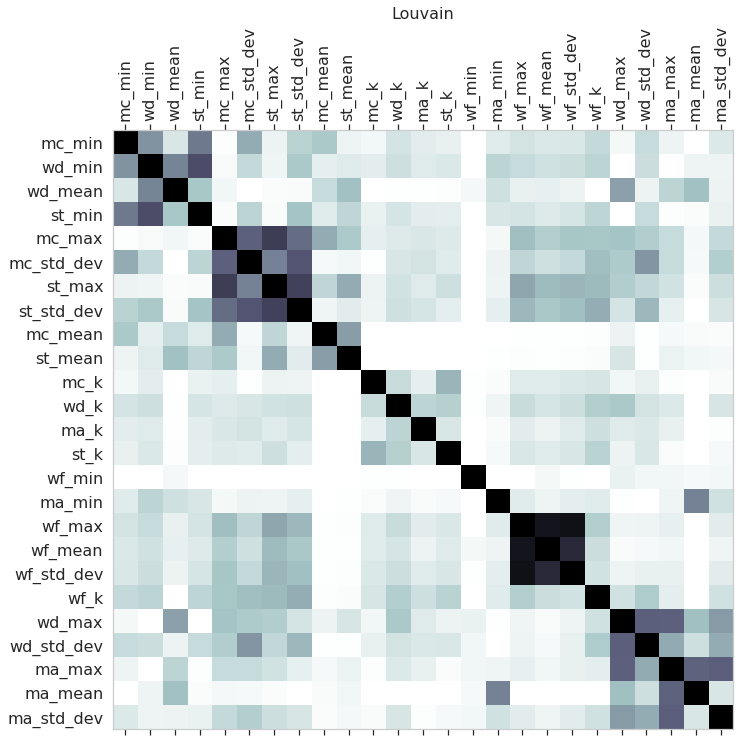

In [118]:
f,(ax) = plt.subplots(1,1,figsize=(10,10))
ax.matshow(adjacency_matrix,cmap='bone_r',  aspect='auto')


ax.grid(False)
ax.set_title('Louvain')
ax.set_yticklabels(new_list)
ax.set_xticklabels(new_list,rotation=90)
ax.yaxis.set_major_locator(plt.MaxNLocator(25))
ax.xaxis.set_major_locator(plt.MaxNLocator(25))

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
f.savefig('../../Figure/louvain.jpeg', dpi=300, bbox_inches = "tight")

## Leiden Community Detection

In [108]:
def change_list_dict(comm_dict):
    # Initialize dictionary with normal values
    dict_with_normal = {}
    # # Iterate through dictionary and join list items
    for key, value in comm_dict.items():
        dict_with_normal[key] = ''.join(str(x) for x in value)

    return dict_with_normal

def leiden_comm_detection(corr_mat):
    # create a graph object from the correlation matrix
    G = networkx.to_networkx_graph(corr_mat, create_using=networkx.Graph())  
    # run the Leiden algorithm
    communities = algorithms.leiden(G, weights='weight')
    community_dict = communities.to_node_community_map()
    leiden_community_dict = change_list_dict(community_dict)
    leiden_comms={}
    for node_index, comm_id in leiden_community_dict.items():
        if comm_id in leiden_comms.keys():
            leiden_comms[comm_id].append(node_index)
        else:
            leiden_comms.setdefault(comm_id, [node_index])
    nodes_leiden_ordered = [node for comm in leiden_comms.values() for node in comm]
        
    adjacency_matrix = np.zeros_like(corr_mat)
    for i in range(corr_mat.shape[0]):
        for j in range(corr_mat.shape[0]):
            r = nodes_leiden_ordered.index(i)
            c = nodes_leiden_ordered.index(j)
            adjacency_matrix[r,c] = corr_mat[i,j] 
            
    return G, leiden_community_dict, nodes_leiden_ordered, adjacency_matrix

In [109]:
G_leiden, leiden_community_dict, nodes_leiden_ordered, adjacency_matrix_leiden = leiden_comm_detection(corr_mat)

In [110]:
### Plotting

n = []
for i in range(len(X)):
    n.append(X[i].name)

dicts_leiden = {}
keys = range(len(X))
values = n
for i in keys:
        dicts[i] = values[i]
        
new_list_label_leiden = sorted(dicts.items(), key=lambda pair: nodes_leiden_ordered.index(pair[0]))

new_list_leiden = []
for i in range(len(new_list_label_leiden)):
    new_list_leiden.append(new_list_label_leiden[i][1])
    
new_list_leiden.insert(0, 0)    

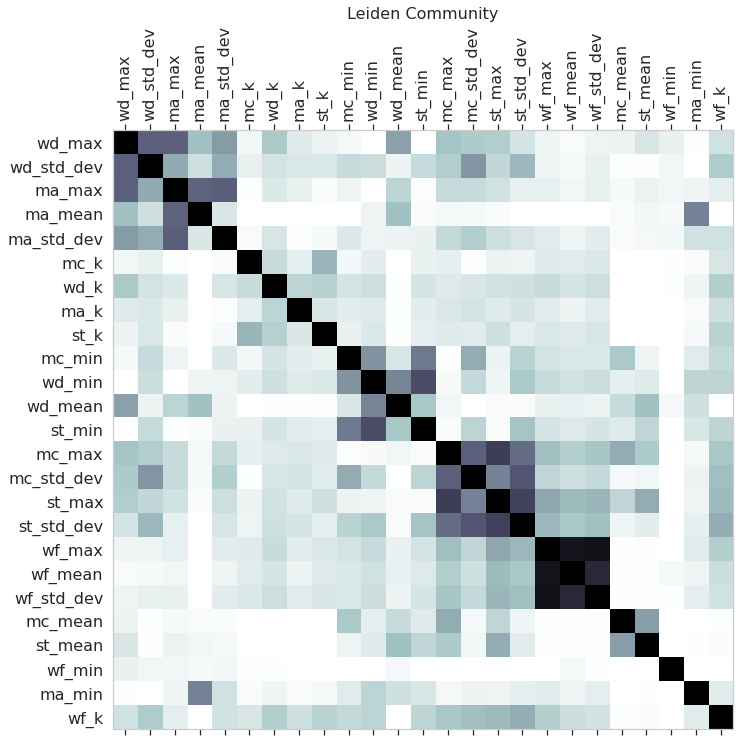

In [114]:
f,(ax) = plt.subplots(1,1,figsize=(10,10))
ax.matshow(adjacency_matrix_leiden,cmap='bone_r',  aspect='auto')


ax.grid(False)
ax.set_title('Leiden Community')
ax.set_xticklabels(new_list_leiden,rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(25))
ax.set_yticklabels(new_list_leiden)
ax.yaxis.set_major_locator(plt.MaxNLocator(25))

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
f.savefig('../../Figure/leiden.jpeg', dpi=300, bbox_inches = "tight")

In [92]:
# Initialize dictionary with normal values
dict_with_normal = {}

# Iterate through dictionary and join list items
for key, value in community_dict.items():
    dict_with_normal[key] = ''.join(str(x) for x in value)

# Print new dictionary with normal values
print(dict_with_normal)


{11: '0', 13: '0', 16: '0', 17: '0', 18: '0', 4: '1', 14: '1', 19: '1', 24: '1', 0: '2', 10: '2', 12: '2', 20: '2', 1: '3', 3: '3', 21: '3', 23: '3', 6: '4', 7: '4', 8: '4', 2: '5', 22: '5', 9: '6', 5: '7', 15: '8'}
